# Connectome meets SNNs
This notebook is a playground for exploring the connection between connectome and spiking neural networks (SNNs). The goal is to understand how the structure of the connectome can be used to inform the structure of SNNs. The notebook is organized as follows:

## Connectome data references
1. Griffa, A., Alemán-Gómez, Y., & Hagmann, P. (2019). Structural and functional connectome from 70 young healthy adults [data set]. Zenodo.
2. Chiang, A. S., Lin, C. Y., Chuang, C. C., Chang, H. M., Hsieh, C. H., Yeh, C. W., ... & Hwang, J. K. (2011). Three-dimensional reconstruction of brain-wide wiring networks in Drosophila at single-cell resolution. Current biology, 21(1), 1-11.
3. Rubinov, M., Ypma, R. J., Watson, C., & Bullmore, E. T. (2015). Wiring cost and topological participation of the mouse brain connectome. Proceedings of the National Academy of Sciences, 112(32), 10032-10037.
4. Bota, M., Sporns, O., & Swanson, L. W. (2015). Architecture of the cerebral cortical association connectome underlying cognition. Proceedings of the National Academy of Sciences, 112(16), E2093-E2101.
5. Modha, D. S., & Singh, R. (2010). Network architecture of the long-distance pathways in the macaque brain. Proceedings of the National Academy of Sciences, 107(30), 13485-13490.
6. Bakker, R., Wachtler, T., & Diesmann, M. (2012). CoCoMac 2.0 and the future of tract-tracing databases. Frontiers in neuroinformatics, 6, 30.



In [ ]:
# TODO evaluate if I need this cell (could be good for actual installation of conn2res from local files for example)
%pip install -q 'tensorflow==2.3.0'
%pip install -q 'numpy==1.18.5'

In [1]:
import os
import time
import multiprocessing as mp
from datetime import datetime

import conn2res
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from conn2res.connectivity import Conn
from conn2res.readout import Readout
from conn2res.reservoir import SpikingNeuralNetwork
from conn2res.tasks import Conn2ResTask
from conn2res import readout

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
print('conn2res version installed:  ', conn2res.__version__)

connectomes = [
    'drosophila',
    'macaque_modha',
    'mouse',
    'rat',
]

print('Available connectomes:  ', connectomes)

conn2res version installed:   v1.0.0-alpha+37.gb5c887f
Available connectomes:   ['drosophila', 'macaque_modha', 'mouse', 'rat']


In [4]:
PROJ_DIR = os.getcwd()
DATA_DIR = os.path.join(PROJ_DIR, 'data')
OUTPUT_DIR = os.path.join(PROJ_DIR, 'results', datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

N_PROCESS = 32
TASK = 'MemoryCapacity'
ALPHAS = np.linspace(0, 2, 41)[1:]
METRIC = ['corrcoef']
metric_kwargs = {
    'multioutput': 'sum',
    'nonnegative': 'absolute'
}
INPUT_GAIN = 0.0001

for connectome in connectomes:
    print(f'Loading connectome data for {connectome}')
    w = np.loadtxt(os.path.join(DATA_DIR, connectome, 'conn.csv'), delimiter=',', dtype=float)
    labels = pd.read_csv(os.path.join(DATA_DIR, connectome, 'labels.csv'))['Sensory'].values
    print(f'Connectome shape:  {w.shape}')
    print(f'Labels shape:  {labels.shape}')

Loading connectome data for drosophila
Connectome shape:  (49, 49)
Labels shape:  (49,)
Loading connectome data for macaque_modha
Connectome shape:  (242, 242)
Labels shape:  (241,)
Loading connectome data for mouse
Connectome shape:  (112, 112)
Labels shape:  (112,)
Loading connectome data for rat
Connectome shape:  (73, 73)
Labels shape:  (73,)


# Defining input encoding strategies
1. Poisson encoding (rate-based encoding)
2. Temporal encoding (spike-based encoding)
3. Rank-order encoding (temporal encoding)
4. Population encoding (spatial encoding)

In [5]:
# Prepare the encoding mechanisms
def generate_poisson_input(dt, time_steps, rates=50):
    """
    Generate input in the form of Poisson spike process using numpy poisson function.
    """
    # Calculate the number of neurons
    num_neurons = len(rates)
    
    # Generate Poisson-distributed spike trains
    poisson_trains = np.random.poisson(lam=np.array(rates)[:, None] * (dt / 1000.), size=(num_neurons, time_steps))
    
    # Convert to binary spike trains (0 or 1)    
    return (poisson_trains > 0).astype(np.int16)

def generate_temporal_input(dt, time_steps, rates=50):
    """
    Generate input in the form of temporal encoding using numpy poisson function.
    """
    # Calculate the number of neurons
    num_neurons = len(rates)
    
    # Generate Poisson-distributed spike trains
    spike_trains = generate_poisson_input(dt, time_steps, rates)
    
    # Convert to spike times
    spike_times = [np.where(spike_trains[i] > 0)[0] for i in range(num_neurons)]
    
    return spike_times

def generate_rank_order_input(dt, time_steps, rates=50):
    """
    Generate input in the form of rank-order encoding using numpy poisson function.
    """
    # Calculate the number of neurons
    num_neurons = len(rates)
    
    # Generate Poisson-distributed spike trains
    spike_trains = generate_poisson_input(dt, time_steps, rates)
    
    # Convert to spike times
    spike_times = [np.where(spike_trains[i] > 0)[0] for i in range(num_neurons)]
    
    # Convert to rank-order encoding
    rank_order = [np.argsort(spike_times[i]) for i in range(num_neurons)]
    
    return rank_order

def generate_population_input(dt, time_steps, rates=50):
    """
    Generate input in the form of population encoding using numpy poisson function.
    """
    # Calculate the number of neurons
    num_neurons = len(rates)
    
    # Generate Poisson-distributed spike trains
    spike_trains = generate_poisson_input(dt, time_steps, rates)
    
    # Convert to population encoding
    population = [np.where(spike_trains[i] > 0)[0] for i in range(num_neurons)]
    
    return population

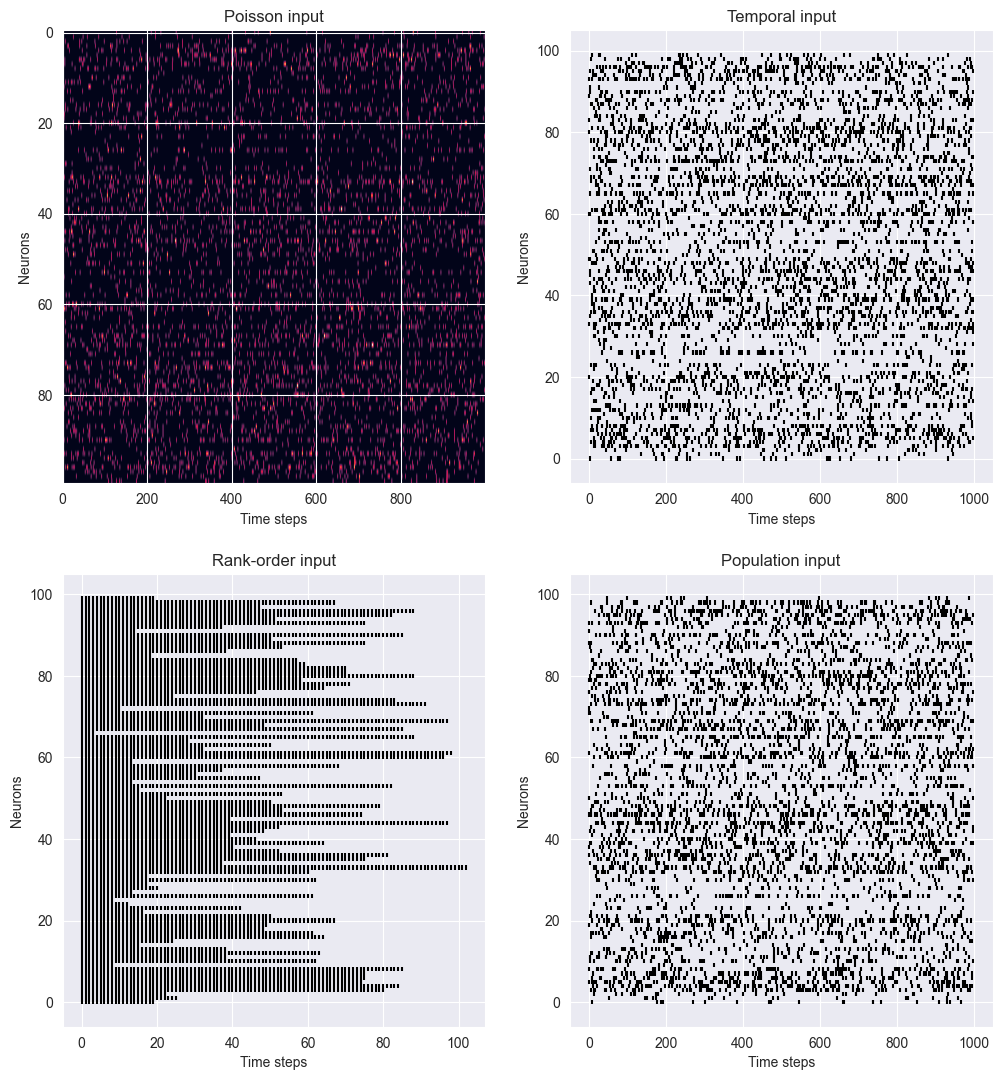

In [6]:
# generate examples of input using different encoding strategies
# TODO make it work with real task data (here - or in a separate cell?)
dt = 1.0
time_steps = 1000
rates = np.random.randint(10, 100, 100)

# Generate input using different encoding strategies
poisson_trains = generate_poisson_input(dt, time_steps, rates)
temporal_input = generate_temporal_input(dt, time_steps, rates)
rank_order_input = generate_rank_order_input(dt, time_steps, rates)
population_input = generate_population_input(dt, time_steps, rates)

# Plot the input encoding strategies
plt.figure(figsize=(12, 20))

# Plot the Poisson input
plt.subplot(321)
plt.imshow(poisson_trains, aspect='auto')
plt.title('Poisson input')
plt.xlabel('Time steps')
plt.ylabel('Neurons')

# Plot the temporal input
plt.subplot(322)
plt.eventplot(temporal_input, colors='black')
plt.title('Temporal input')
plt.xlabel('Time steps')
plt.ylabel('Neurons')

# Plot the rank-order input
plt.subplot(323)
plt.eventplot(rank_order_input, colors='black')
plt.title('Rank-order input')
plt.xlabel('Time steps')
plt.ylabel('Neurons')

# Plot the population input
plt.subplot(324)
plt.eventplot(population_input, colors='black')
plt.title('Population input')
plt.xlabel('Time steps')
plt.ylabel('Neurons')

plt.show()

# Defining the task
The task is a one-step inference task, where the goal is to infer the output based on the input. The task is defined as follows:
1. Input: 100 neurons with Poisson input encoding
2. Output: 100 neurons with Poisson input encoding
3. Task: Infer the output based on the input
4. Metric: Mean squared error (MSE)
5. Readout: Ridge regression
6. Output: Mean squared error (MSE) for different values of alpha
7. Alpha: Regularization parameter for ridge regression
8. Connectome: Empirical connectome for different species
9. Null models: 500 null models for each species
10. Output: Save the results in a CSV file

In [ ]:
# Define the task (see sernn repository on GitHub to learn more todo add link)
class mazeGeneratorI():
    """
    Objects of the mazeGeneratorI class can create numpy and tf datasets of the first choice of the maze task.
    Task structure:
        Goal presentation, followed by delay period, followed by choice options.
    Response:
        One response required from agent at end of episode. Direction (Left, Up, Right, Down) of first step.
    Encoding:
        Both observations and labels are OneHot encoded.
    Usage:
        The two only function a user should need to access are "construct_numpy_data" and "construct_tf_data"
    Options:
        Both data construction methods have an option to shuffle the labels of data.
        The numpy data construction method allows to also return the maze identifiers.
    """
    def __init__(self, goal_presentation_steps, delay_steps, choices_presentation_steps):
        self.version = 'v1.2.0'

        # Import variables defining episode
        self.goal_presentation_steps = goal_presentation_steps
        self.delay_steps = delay_steps
        self.choices_presentation_steps = choices_presentation_steps

        # Construct mazes dataframe
        ## Add encoded versions of the goal / choices presentations and the next step response
        self.mazesdf = self.import_maze_dic()
        self.mazesdf['Goal_Presentation'] = self.mazesdf['goal'].map({
            7:np.concatenate((np.array([1,0,0,0]),np.repeat(0,4))),
            9:np.concatenate((np.array([0,1,0,0]),np.repeat(0,4))),
            17:np.concatenate((np.array([0,0,1,0]),np.repeat(0,4))),
            19:np.concatenate((np.array([0,0,0,1]),np.repeat(0,4)))})
        self.mazesdf['Choices_Presentation']=self.mazesdf['ChoicesCategory'].map(lambda x: self.encode_choices(x=x))
        self.mazesdf['Step_Encoded']=self.mazesdf['NextFPmap'].map(lambda x: self.encode_next_step(x=x))

    def construct_numpy_data(self, number_of_problems, return_maze_identifiers = False, np_shuffle_data = False):
        # Create a new column which hold the vector for each problem
        self.mazesdf['Problem_Vec']=self.mazesdf.apply(lambda x: self.create_problem_observation(row= x,goal_presentation_steps= self.goal_presentation_steps,delay_steps= self.delay_steps,choices_presentation_steps= self.choices_presentation_steps), axis=1)
        # Set a random order of maze problems for the current session
        self.mazes_order = np.random.randint(0,8,number_of_problems)

        # Create vectors, holding observations and labels
        session_observation =np.array([])
        session_labels = np.array([])
        for i in self.mazes_order:
            session_observation = np.append(session_observation,self.mazesdf.iloc[i]['Problem_Vec'])
            session_labels = np.append(session_labels,self.mazesdf.iloc[i]['Step_Encoded'])

        # Reshape vectors to fit network observation and response space
        session_length = self.goal_presentation_steps + self.delay_steps + self.choices_presentation_steps
        session_observation = np.reshape(session_observation, (-1,session_length,8)).astype('float32')
        session_labels = np.reshape(session_labels, (-1,4)).astype('float32')

        # If np_shuffle_data == 'Labels, the order of labels is shuffled to randomise correct answers
        if np_shuffle_data == 'Labels':
          shuffle_generator = np.random.default_rng(38446)
          shuffle_generator.shuffle(session_labels,axis=0)

        # If return_maze_identifiers == 'IDs', return the array with maze IDs alongside the regular returns (observations, labels)
        if return_maze_identifiers == 'IDs':
          return session_observation, session_labels, self.mazes_order

        return session_observation, session_labels

    def construct_tf_data(self, number_of_problems, batch_size, tf_shuffle_data = False):
        # Create dataset as described by numpy dataset function and transform it into a TF dataset
        npds, np_labels = self.construct_numpy_data(number_of_problems=number_of_problems, np_shuffle_data = tf_shuffle_data)
        tfdf = tf.data.Dataset.from_tensor_slices((npds, np_labels))
        tfdf = tfdf.batch(batch_size)
        return tfdf

    def reset_construction_params(self, goal_presentation_steps, delay_steps, choices_presentation_steps):
        self.goal_presentation_steps = goal_presentation_steps
        self.delay_steps = delay_steps
        self.choices_presentation_steps = choices_presentation_steps

    def import_maze_dic(self, mazeDic=None):
        if mazeDic == None:
            # Set up dataframe with first choices of maze task
            ## The dictionary was generated using MazeMetadata.py (v1.0.0) and the following call:
            ### mazes.loc[(mazes['Nsteps']==2)&(mazes['ChoiceNo']=='ChoiceI')][['goal','ChoicesCategory','NextFPmap']].reset_index(drop=True).to_dict()
            self.mazesDic = {'goal': {0: 9, 1: 9, 2: 19, 3: 17, 4: 17, 5: 7, 6: 19, 7: 7},
            'ChoicesCategory': {0: 'ul',
            1: 'rd',
            2: 'ld',
            3: 'rd',
            4: 'ul',
            5: 'ur',
            6: 'lr',
            7: 'lr'},
            'NextFPmap': {0: 'u', 1: 'r', 2: 'd', 3: 'd', 4: 'l', 5: 'u', 6: 'r', 7: 'l'}}
        else:
            self.mazesDic = mazesDic

        # Create and return dataframe
        return pd.DataFrame(self.mazesDic)

    def encode_choices(self, x):
        # Helper function to create the observation vector for choice periods
        choices_sec = np.repeat(0,4)
        choicesEncoding = pd.Series(list(x))
        choicesEncoding = choicesEncoding.map({'l':1,'u':2,'r':3,'d':4})
        for encodedChoice in choicesEncoding:
            choices_sec[encodedChoice-1]=1
        return np.concatenate((np.repeat(0,4),choices_sec))

    def encode_next_step(self, x):
        # Helper function to change the response / action to a OneHot encoded vector
        step_sec = np.repeat(0,4)
        stepEncoding = pd.Series(list(x))
        stepEncoding = stepEncoding.map({'l':1,'u':2,'r':3,'d':4})
        for encodedStep in stepEncoding:
            step_sec[encodedStep-1]=1
        return step_sec

    def create_problem_observation(self, row, goal_presentation_steps, delay_steps, choices_presentation_steps):
        # Helper function to create one vector describing the entire outline of one maze problem (Goal presentation, Delay Period, and Choices Presentation)
        goal_vec = np.tile(row['Goal_Presentation'], goal_presentation_steps)
        delay_vec = np.tile(np.repeat(0,8), delay_steps)
        choices_vec = np.tile(row['Choices_Presentation'], choices_presentation_steps)
        problem_vec = np.concatenate((goal_vec,delay_vec,choices_vec))
        return problem_vec

    def __repr__(self):
        return '\n'.join([
            f'Maze DataSet Generator',
            f'Goal Presentation Steps: {self.goal_presentation_steps}',
            f'Delay Steps: {self.delay_steps}',
            f'Choices Presentation Steps: {self.choices_presentation_steps}'])
    
# This constructor might run for around a minute to generate the dataset
gen = mazeGeneratorI(goal_presentation_steps=20,delay_steps=10,choices_presentation_steps=20)
tfdf = gen.construct_tf_data(number_of_problems=5120, batch_size=128)
tfdf_test = gen.construct_tf_data(number_of_problems=2560, batch_size=128)
tfdf_val = gen.construct_tf_data(number_of_problems=2560, batch_size=128)
print(tfdf)

In [ ]:
# define the experiment workflow
def run_workflow(
    w, x, y, input_nodes, output_nodes, rewire=True, filename=None
):
    conn = Conn(w=w)
    if rewire:
        conn.randomize(swaps=10)

    conn.scale_and_normalize()

    w_in = np.zeros((1, conn.n_nodes))
    w_in[:, input_nodes] = np.eye(1)
    
    # TODO initialize the reservoir with the actual connectivity matrices of the different species

    snn = SpikingNeuralNetwork(w=conn.w, activation_function='tanh')
    readout_module = Readout(estimator=readout.select_model(y))

    x_train, x_test, y_train, y_test = readout.train_test_split(x, y)

    df_alpha = []
    for alpha in ALPHAS:

        print(f'\n\t\t\t----- alpha = {alpha} -----')

        snn.w = alpha * conn.w

        rs_train = snn.simulate(
            ext_input=x_train, w_in=w_in,
            output_nodes=output_nodes
        )

        rs_test = snn.simulate(
            ext_input=x_test, w_in=w_in,
            output_nodes=output_nodes
        )

        df_res = readout_module.run_task(
            X=(rs_train, rs_test), y=(y_train, y_test),
            sample_weight=None, metric=METRIC,
            readout_modules=None, readout_nodes=None,
            **metric_kwargs
        )

        df_res['alpha'] = np.round(alpha, 3)
        df_alpha.append(df_res)

    df_alpha = pd.concat(df_alpha, ignore_index=True)
    df_alpha = df_alpha[['alpha', METRIC[0]]]
    df_alpha.to_csv(
        os.path.join(OUTPUT_DIR, f'{filename}_scores.csv'),
        index=False
        )

In [ ]:
def run_experiment(connectome, x, y):
    w = np.loadtxt(os.path.join(DATA_DIR, connectome, 'conn.csv'), delimiter=',', dtype=float)
    labels = pd.read_csv(os.path.join(DATA_DIR, connectome, 'labels.csv'))['Sensory'].values

    # run workflow for empirical network
    run_workflow(
        w.copy(), x, y,
        input_nodes=np.where(labels == 1)[0],
        output_nodes=np.where(labels == 0)[0],
        rewire=False,
        filename=f'{connectome}_empirical'
    )

    # run workflow for nulls
    params = []
    for i in range(500):
        params.append(
            {
                'w': w.copy(),
                'x': x,
                'y': y,
                'input_nodes': np.where(labels == 1)[0],
                'output_nodes': np.where(labels == 0)[0],
                'filename': f'{connectome}_null_{i}'
            }
        )

    print('\nINITIATING PROCESSING TIME')
    t0 = time.perf_counter()

    pool = mp.Pool(processes=N_PROCESS)
    res = [pool.apply_async(run_workflow, (), p) for p in params]
    for r in res: r.get()
    pool.close()

    print('\nTOTAL PROCESSING TIME')
    print(time.perf_counter()-t0, "seconds process time")
    print('END')

In [ ]:
# run the actual experiment
# TODO this has to be the one-step inference task
task = Conn2ResTask(name=TASK)
x, y = task.fetch_data(n_trials=4050, input_gain=INPUT_GAIN)

# Save the input and output data
np.save(os.path.join(OUTPUT_DIR, 'input.npy'), x)
np.save(os.path.join(OUTPUT_DIR, 'output.npy'), y)

connectomes = [
    'drosophila',
    'macaque_modha',
    'mouse',
    'rat'
]

for connectome in connectomes:
    run_experiment(connectome, x, y)

# Evaluate the results

In [ ]:
# Load the results
results = {}

for connectome in connectomes:
    results[connectome] = {}
    results[connectome]['empirical'] = pd.read_csv(
        os.path.join(OUTPUT_DIR, f'{connectome}_empirical_scores.csv')
    )

    results[connectome]['null'] = []
    for i in range(500):
        results[connectome]['null'].append(
            pd.read_csv(
                os.path.join(OUTPUT_DIR, f'{connectome}_null_{i}_scores.csv')
            )
        )